In [2]:
import os
import glob
from typing import Literal, Optional, Tuple

import numpy as np
import xarray as xr
from xclim import sdba


/home/aninotna/.conda/envs/pv-cf-cmip6/lib/python3.13/site-packages/xclim/sdba.py:12: UserWarning: The `xclim.sdba` module has been split into its own package `xsdba`. Users are encouraged to use `xsdba` directly. For the time being, `xclim.sdba` will import `xsdba` to allow for API compatibility. This behaviour may change in the future. For more information, see: https://xsdba.readthedocs.io/en/stable/xclim_migration_guide.html
  warnings.warn(


In [3]:
# =========================
# Configuración del usuario
# =========================
ZARR_PATH = "/home/aninotna/magister/tesis/justh2_pipeline/data/solar/solar_diario_grilla.zarr"  # ghi diario
CMIP6_DIR_HIST = "/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/historical"           # rsds Amon
CMIP6_ROOT = os.path.dirname(CMIP6_DIR_HIST)  # raíz cmip6 (para buscar /ssp245, /ssp370, etc.)

TRAIN_START = "2004-01-01"
TRAIN_END   = "2014-12-31"

In [4]:
# Si las unidades no coinciden, ajustar aquí (ver función normalize_units)
GHI_UNIT_HINT = "W m-2"  # o "Wh m-2 day-1", etc. (placeholder informativo)
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

# =========================
# Helpers de estandarización
# =========================

In [5]:
def to_lon180(lon: xr.DataArray) -> xr.DataArray:
    """Convierte longitudes a rango [-180, 180) y ordena."""
    lon2 = ((lon + 180) % 360) - 180
    return xr.DataArray(lon2.data, dims=lon.dims, coords=lon.coords, attrs=lon.attrs)

def standardize_latlon(ds: xr.Dataset) -> xr.Dataset:
    """Renombra latitude/longitude → lat/lon y asegura lon en [-180,180)."""
    ren = {}
    if "latitude" in ds.coords: ren["latitude"] = "lat"
    if "longitude" in ds.coords: ren["longitude"] = "lon"
    ds = ds.rename(ren) if ren else ds

    # Si lon está en [0,360), convértelo a [-180,180)
    if "lon" in ds.coords:
        lon = ds["lon"]
        if np.nanmax(lon) > 180:
            new_lon = to_lon180(lon)
            ds = ds.assign_coords(lon=new_lon).sortby("lon")

    return ds

def decode_time_cf(ds: xr.Dataset) -> xr.Dataset:
    """
    Decodifica tiempos CF y usa cftime si el calendario no es gregoriano.
    Evita depender de xclim.core.calendar.convert_calendar.
    """
    try:
        ds = xr.decode_cf(ds, decode_times=time_coder)  # => clave: cftime para 360/365_day
    except Exception:
        pass
    return ds

def normalize_units_to_wm2(da: xr.DataArray, src_hint: Optional[str] = None) -> xr.DataArray:
    """
    Normaliza unidades a W/m² si fuera necesario.
    - Si ya está en W/m² mensual medio, retorna igual.
    - Ajusta aquí si tu GHI diario viene en Wh/m²/día (común en satelital):
      Para mensual medio en W/m², puedes:
      1) convertir Wh/m²/día → W/m² promedio diario: divide por 24
      2) luego promediar mensual (ya hacemos resample.mean()).
    """
    units = (da.attrs.get("units") or "").lower()
    src = (src_hint or "").lower()

    # Ejemplo de conversión simple si detectas Wh m-2 day-1:
    if "wh" in units or "wh" in src:
        # Wh/m²/día → W/m² (promedio sobre 24h): divide por 24
        out = da / 24.0
        out.attrs["units"] = "W m-2"
        return out

    # Por defecto, retorna sin cambios
    return da


In [6]:
def single_time_chunk(da: xr.DataArray, max_xy: int = 50) -> xr.DataArray:
    chunks = {"time": -1}                     # => un solo chunk a lo largo de time
    if "lat" in da.dims: chunks["lat"] = min(da.sizes["lat"], max_xy)
    if "lon" in da.dims: chunks["lon"] = min(da.sizes["lon"], max_xy)
    if "y"   in da.dims: chunks["y"]   = min(da.sizes["y"],   max_xy)
    if "x"   in da.dims: chunks["x"]   = min(da.sizes["x"],   max_xy)
    return da.chunk(chunks)

In [7]:
# => NUEVO: construir intersección de meses y reasignar un índice mensual común
import pandas as pd

def harmonize_training_time(ref_m: xr.DataArray, hist_m: xr.DataArray,
                            start: str, end: str) -> tuple[xr.DataArray, xr.DataArray]:
    # Filtra período por años (robusto a cftime)
    y0, y1 = int(start[:4]), int(end[:4])
    ref = ref_m.where((ref_m.time.dt.year >= y0) & (ref_m.time.dt.year <= y1), drop=True)
    his = hist_m.where((hist_m.time.dt.year >= y0) & (hist_m.time.dt.year <= y1), drop=True)

    # => construye llaves (YYYY-MM) y toma intersección
    ref_ym = pd.Index([f"{int(y):04d}-{int(m):02d}" for y, m in zip(ref.time.dt.year.values, ref.time.dt.month.values)])
    his_ym = pd.Index([f"{int(y):04d}-{int(m):02d}" for y, m in zip(his.time.dt.year.values, his.time.dt.month.values)])
    common = ref_ym.intersection(his_ym).sort_values()

    if len(common) == 0:
        raise ValueError("No hay meses comunes entre ref e hist en el periodo dado.")

    # => selecciona los meses comunes manteniendo el orden
    ref_idx = [i for i, k in enumerate(ref_ym) if k in common]
    his_idx = [i for i, k in enumerate(his_ym) if k in common]
    ref = ref.isel(time=ref_idx)
    his = his.isel(time=his_idx)

    # => reasigna un índice mensual sintético idéntico para ambos (inicio de mes)
    new_time = pd.to_datetime(common.astype(str) + "-01")  # datetime64[ns]
    ref = ref.assign_coords(time=("time", new_time))
    his = his.assign_coords(time=("time", new_time))
    return ref, his


In [8]:
import numpy as np
import xarray as xr

def mask_bad_cells(
    ref: xr.DataArray,
    hist: xr.DataArray,
    min_total: int = 60,       # meses válidos totales (2004–2014 son 132)
    min_per_month: int | None = 6,  # válidos por cada mes (0–11 posible); None para desactivar
) -> tuple[xr.DataArray, xr.DataArray]:
    """
    Enmascara celdas (lat/lon) con datos insuficientes en el período de entrenamiento.
    Requiere al menos `min_total` meses válidos en total y, opcionalmente,
    al menos `min_per_month` observaciones por cada mes del año.
    """
    # 1) criterio total
    ok_tot_ref  = ref.notnull().sum("time")  >= min_total
    ok_tot_hist = hist.notnull().sum("time") >= min_total
    ok_total = ok_tot_ref & ok_tot_hist

    # 2) criterio por mes (opcional)
    if min_per_month is not None:
        ref_mon  = ref.notnull().groupby("time.month").sum("time")
        hist_mon = hist.notnull().groupby("time.month").sum("time")
        ok_mon = (ref_mon >= min_per_month).all("month") & (hist_mon >= min_per_month).all("month")
        # ok_mon tiene dims lat/lon; combínalo con ok_total
        ok = ok_total & ok_mon
    else:
        ok = ok_total

    # 3) aplicar máscara (se difunde a la dimensión time automáticamente)
    ref_m  = ref.where(ok)
    hist_m = hist.where(ok)
    return ref_m, hist_m



# =========================
# Lectura y preprocesamiento
# =========================

In [9]:
def open_obs_monthly(zarr_path: str, var: str = "ghi", chunks="auto") -> xr.DataArray:
    ds = xr.open_zarr(zarr_path, chunks=chunks)
    if "time" not in ds.coords and "date" in ds.coords:
        ds = ds.rename({"date": "time"})
    ds = decode_time_cf(ds)  # => usar cftime si aplica
    if var not in ds:
        raise KeyError(f"Variable '{var}' no está en {zarr_path}. Vars: {list(ds.data_vars)}")

    da = ds[var]
    # (Opcional) normaliza unidades si tu GHI viene en Wh/m²/día
    units = (da.attrs.get("units") or "").lower()
    if "wh" in units:
        da = da / 24.0
        da.attrs["units"] = "W m-2"

    # => Mensual por inicio de mes (funciona con cftime)
    dam = da.resample(time="MS").mean("time", skipna=True)
    dam = dam.rename("rsds")
    return dam

In [10]:
def open_cmip6_file(path: str, var: str = "rsds", chunks=None) -> xr.DataArray:
    # => Evitar chunks="auto" aquí y permitir cftime (calendarios 360/365_day)
    ds = xr.open_dataset(
        path,
        decode_times=time_coder,
        chunks={},                      # => desactiva auto-chunking al abrir
        drop_variables=[                # => opcional: elimina bounds que a veces dan lata
            v for v in ["time_bnds", "time_bounds", "lon_bnds", "lat_bnds"]
            if v in xr.open_dataset(path, decode_times=False).variables
        ],
    )

    # => Renombrar coords si aplica y normalizar longitudes
    ren = {}
    if "latitude" in ds.coords: ren["latitude"] = "lat"
    if "longitude" in ds.coords: ren["longitude"] = "lon"
    if ren:
        ds = ds.rename(ren)
    if "lon" in ds.coords and float(ds.lon.max()) > 180:
        lon2 = ((ds.lon + 180) % 360) - 180
        ds = ds.assign_coords(lon=lon2).sortby("lon")

    if var not in ds:
        raise KeyError(f"Variable '{var}' no está en {path}. Vars: {list(ds.data_vars)}")

    da = ds[var]

    # => Ahora sí: chunkear SOLO la variable numérica
    #    (elige tamaños razonables; ajusta a tu gusto)
    chunk_map = {}
    for d in da.dims:
        if d == "time":
            chunk_map[d] = 120         # ~10 años mensuales por chunk
        elif d in ("lat", "y"):
            chunk_map[d] = min(da.sizes[d], 50)
        elif d in ("lon", "x"):
            chunk_map[d] = min(da.sizes[d], 50)
        else:
            chunk_map[d] = -1          # todo de una
    da = da.chunk(chunk_map)

    return da

In [11]:
def find_hist_file(cmip6_hist_dir: str, model_like: str) -> str:
    pats = [
        os.path.join(cmip6_hist_dir, f"rsds_Amon_*{model_like}*historical*.nc"),
        os.path.join(cmip6_hist_dir, "**", f"rsds_Amon_*{model_like}*historical*.nc"),
    ]
    for p in pats:
        files = glob.glob(p, recursive=True)
        if files:
            return files[0]
    raise FileNotFoundError(f"No se encontró histórico para modelo ~ '{model_like}' en {cmip6_hist_dir}")

def find_ssp_file(cmip6_root: str, ssp: str, model_like: str) -> str:
    ssp_dir = os.path.join(cmip6_root, ssp)
    print(f"[Info] Buscando SSP '{ssp}' para modelo ~ '{model_like}' en {ssp_dir}...")
    pats = [
        os.path.join(ssp_dir, f"**/rsds_Amon_*{model_like}*{ssp}*.nc"),
        os.path.join(ssp_dir, f"rsds_Amon_*{model_like}*{ssp}*.nc"),
    ]
    for p in pats:
        files = glob.glob(p, recursive=True)
        if files:
            return files[0]
    raise FileNotFoundError(f"No se encontró archivo SSP '{ssp}' para modelo ~ '{model_like}' en {ssp_dir}")


In [12]:
def regrid_to_obs(sim: xr.DataArray, obs_like: xr.DataArray, method: str = "linear") -> xr.DataArray:
    """Interpola (lon,lat) del simulador al grid de observaciones."""
    # Asegurar nombres
    if not {"lat", "lon"}.issubset(obs_like.coords):
        raise ValueError("Observaciones no tienen coords lat/lon.")
    sim = standardize_latlon(sim.to_dataset(name=sim.name)).to_array()[0]
    # Interpolación bilineal (o 'nearest' si prefieres)
    return sim.interp(lon=obs_like["lon"], lat=obs_like["lat"], method=method)

def select_period(da: xr.DataArray, start: str, end: str) -> xr.DataArray:
    """
    Selecciona por AÑOS usando .dt.year para evitar issues de calendario.
    """
    y0, y1 = int(start[:4]), int(end[:4])
    return da.where((da.time.dt.year >= y0) & (da.time.dt.year <= y1), drop=True)


# =========================
# Entrenamiento y ajuste
# =========================

In [13]:
def train_bias_correction(ref, hist, method="EQM", nquantiles=50, group="time.month"):
    grouper = sdba.Grouper(group)
    if method == "EQM":
        return sdba.EmpiricalQuantileMapping.train(
            ref=ref, hist=hist, nquantiles=nquantiles, group=grouper
        )
    else:
        return sdba.QuantileDeltaMapping.train(
            ref=ref, hist=hist, nquantiles=nquantiles, group=grouper, kind="+"
        )

def apply_bias_correction(bc, sim, extrapolation="constant"):
    return bc.adjust(sim=sim, extrapolation=extrapolation)


# =========================
# Guardado y gráficos
# =========================

In [14]:
def save_qm_nc(da: xr.DataArray, out_path: str):
    da.name = "rsds"
    comp = dict(zlib=True, complevel=4)
    encoding = {da.name: {"dtype": "float32", "_FillValue": -9999.0, **comp}}
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    da.to_netcdf(out_path, encoding=encoding)

def area_weighted_mean(da: xr.DataArray) -> xr.DataArray:
    """Promedio espacial ponderado por cos(lat)."""
    w = np.cos(np.deg2rad(da["lat"]))
    W = w / w.mean()  # normaliza pesos
    return (da * W).mean(("lat", "lon"), skipna=True)


In [15]:
def to_pandas_month_index(da: xr.DataArray) -> xr.DataArray:
    y = da.time.dt.year.values
    m = da.time.dt.month.values
    new_time = pd.to_datetime([f"{int(yy):04d}-{int(mm):02d}-01" for yy, mm in zip(y, m)])  # =>
    return da.assign_coords(time=("time", new_time))  # =>

In [16]:
def quick_validation_plot(obs_m, hist_m, hist_qm_m, fut_qm_m=None, fut_slice=None, title_prefix=""):
    import matplotlib.pyplot as plt

    # => convertir a índice pandas solo para graficar
    obs_p     = to_pandas_month_index(obs_m)     # =>
    hist_p    = to_pandas_month_index(hist_m)    # =>
    hist_qm_p = to_pandas_month_index(hist_qm_m) # =>
    fut_qm_p  = to_pandas_month_index(fut_qm_m) if fut_qm_m is not None else None  # =>

    # Promedio espacial ponderado
    s_obs     = area_weighted_mean(obs_p).to_series()
    s_hist    = area_weighted_mean(hist_p).to_series()
    s_hist_qm = area_weighted_mean(hist_qm_p).to_series()

    plt.figure(figsize=(10, 4))
    s_obs.loc[TRAIN_START:TRAIN_END].plot(label="Obs (ghi→mensual)", lw=1)
    s_hist.loc[TRAIN_START:TRAIN_END].plot(label="CMIP6 crudo (hist)", lw=1, alpha=0.7)
    s_hist_qm.loc[TRAIN_START:TRAIN_END].plot(label="CMIP6 corregido (hist, QM)", lw=1.5)
    plt.legend(); plt.title(f"{title_prefix} Validación (2004–2014)"); plt.ylabel("rsds [W/m²]"); plt.xlabel("")
    plt.tight_layout(); plt.show()

    if fut_qm_p is not None and fut_slice is not None:
        s_fut_qm = area_weighted_mean(fut_qm_p).to_series()
        t0, t1 = fut_slice
        plt.figure(figsize=(10, 3))
        s_fut_qm.loc[t0:t1].plot(label=f"Futuro corregido {t0[:4]}–{t1[:4]}", lw=1.5)
        plt.legend(); plt.title(f"{title_prefix} Futuro corregido ({t0}–{t1})"); plt.ylabel("rsds [W/m²]"); plt.xlabel("")
        plt.tight_layout();

# =========================
# Pipeline principal
# =========================

In [17]:
def run_qm_for_model(
    model_like: str,
    ssp: str = "ssp245",
    sim_start: str = "2023-01-01",
    sim_end: str = "2100-12-31",
    method: Literal["EQM", "QDM"] = "EQM",
    out_dir: Optional[str] = None,
    interp_method: str = "linear",
    nquantiles: int = 50,
):
    """
    Ejecuta todo el flujo para un modelo y un SSP.
    """
    # 1) Observaciones (ghi → mensual)
    obs_m = open_obs_monthly(ZARR_PATH, var="ghi", chunks="auto")

    # 2) CMIP6 histórico
    hist_path = find_hist_file(CMIP6_DIR_HIST, model_like=model_like)
    hist_m = open_cmip6_file(hist_path, var="rsds", chunks="auto")
    # Rejilla al grid de obs
    hist_m_rg = regrid_to_obs(hist_m, obs_m, method=interp_method)

    # 3) Recorte periodo de entrenamiento
    ref_train, hist_train = harmonize_training_time(obs_m, hist_m_rg, TRAIN_START, TRAIN_END)  # =>

    ref_train, hist_train = mask_bad_cells(ref_train, hist_train, min_total=60, min_per_month=6)

    assert np.array_equal(ref_train.time.values, hist_train.time.values), "time no coincide tras armonizar"

    ref_train  = single_time_chunk(ref_train).assign_attrs(units="W m-2")
    hist_train = single_time_chunk(hist_train).assign_attrs(units="W m-2")

    ref_train  = ref_train.assign_attrs(units="W m-2")
    hist_train = hist_train.assign_attrs(units="W m-2")

    # 4) Entrenar
    bc = train_bias_correction(ref=ref_train, hist=hist_train, method=method,
                               nquantiles=nquantiles, group="time.month")  

    # 5) Aplicar en histórico (para validar)
    # => opcional pero recomendable: un solo chunk en time también al ajustar
    hist_m_rg = single_time_chunk(hist_m_rg).assign_attrs(units="W m-2")    # => evita el mismo error en adjust
    hist_qm   = apply_bias_correction(bc, hist_m_rg)

    # 6) Futuro SSP (2023–2100)
    print(f"[Info] Procesando futuro {ssp} para modelo ~ '{model_like}'...")
    ssp_path = find_ssp_file(CMIP6_ROOT, ssp=ssp, model_like=model_like)
    fut_m = open_cmip6_file(ssp_path, var="rsds", chunks="auto")  # si dejaste chunks={}, ok igual
    fut_m_rg = regrid_to_obs(fut_m, obs_m, method=interp_method)
    fut_m_rg = select_period(fut_m_rg, sim_start, sim_end)

    # => un solo chunk en time antes de ajustar al futuro
    fut_m_rg = single_time_chunk(fut_m_rg).assign_attrs(units="W m-2")
    fut_qm   = apply_bias_correction(bc, fut_m_rg)

    # 7) Guardar
    if out_dir is None:
        out_dir = os.path.join(CMIP6_ROOT, "bias_corrected_qm")
    os.makedirs(out_dir, exist_ok=True)

    model_tag = os.path.basename(hist_path).split("_")[2] if "rsds_Amon_" in os.path.basename(hist_path) else model_like
    out_hist = os.path.join(out_dir, f"rsds_qm_{model_tag}_historical.nc")
    out_fut  = os.path.join(out_dir, f"rsds_qm_{model_tag}_{ssp}.nc")

    save_qm_nc(hist_qm, out_hist)
    save_qm_nc(fut_qm, out_fut)

    # 8) (Opcional) Gráfica rápida de validación + vistazo futuro
    try:
        quick_validation_plot(
            obs_m=obs_m,
            hist_m=hist_m_rg,
            hist_qm_m=hist_qm,
            fut_qm_m=fut_qm,
            fut_slice=("2040-01-01", "2060-12-31"),
            title_prefix=f"{model_tag} / {ssp} —",
        )
    except Exception as e:
        print(f"[Aviso] No se pudo graficar: {e}")

    return out_hist, out_fut

[Info] Procesando futuro ssp245 para modelo ~ 'access_cm2'...
[Info] Buscando SSP 'ssp245' para modelo ~ 'access_cm2' en /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/ssp245...


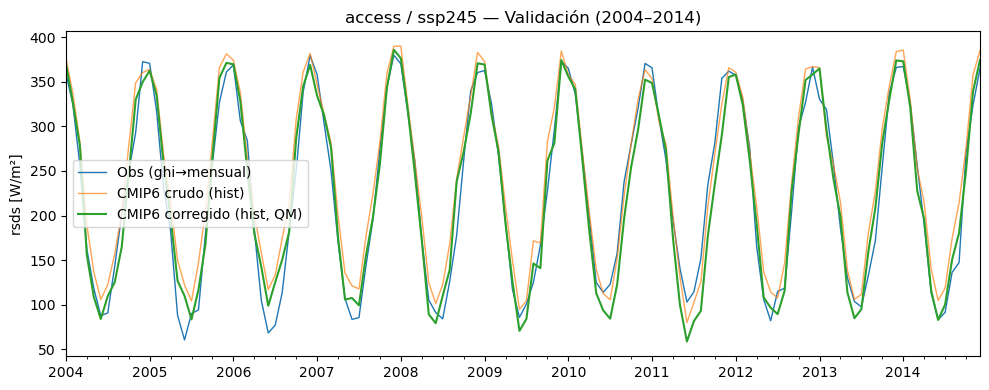

[Info] Procesando futuro ssp370 para modelo ~ 'access_cm2'...
[Info] Buscando SSP 'ssp370' para modelo ~ 'access_cm2' en /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/ssp370...


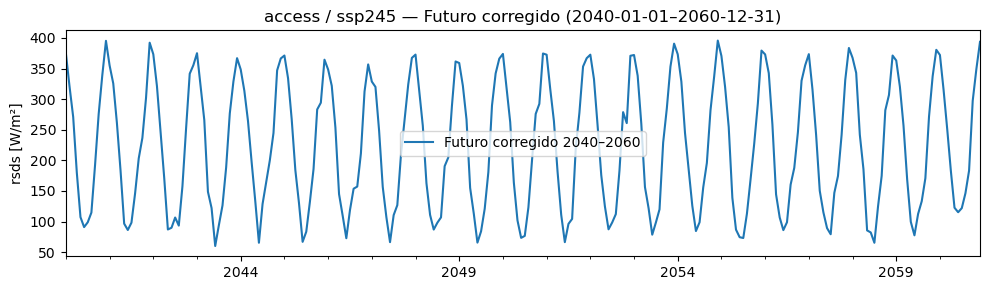

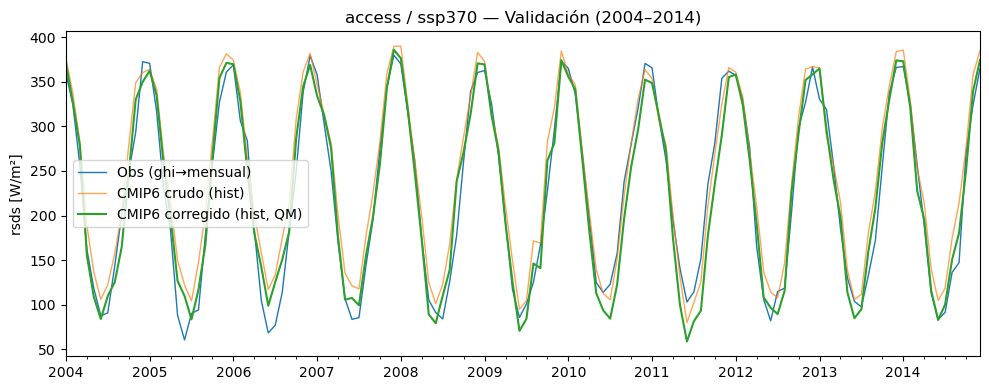

[Info] Procesando futuro ssp585 para modelo ~ 'access_cm2'...
[Info] Buscando SSP 'ssp585' para modelo ~ 'access_cm2' en /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/ssp585...


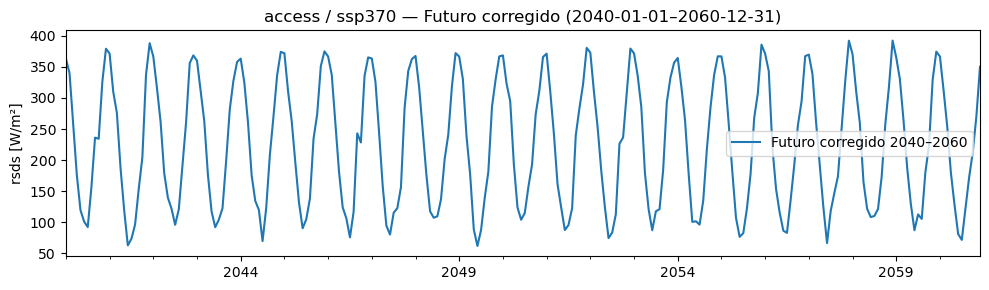

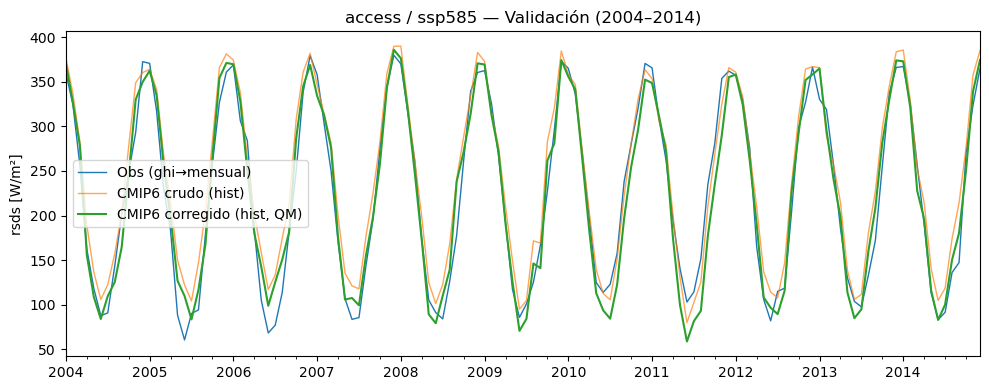

[Info] Procesando futuro ssp245 para modelo ~ 'gfdl_esm4'...
[Info] Buscando SSP 'ssp245' para modelo ~ 'gfdl_esm4' en /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/ssp245...


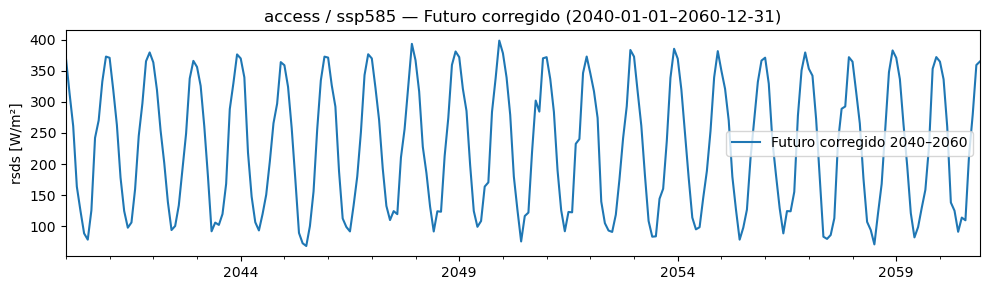

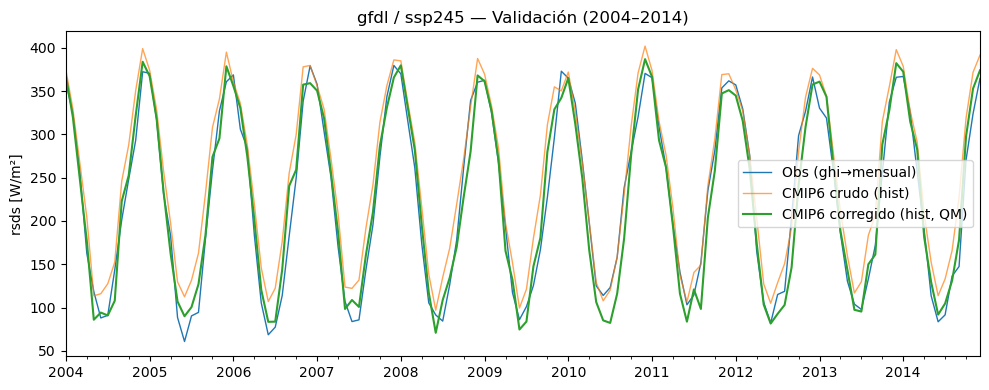

[Info] Procesando futuro ssp370 para modelo ~ 'gfdl_esm4'...
[Info] Buscando SSP 'ssp370' para modelo ~ 'gfdl_esm4' en /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/ssp370...


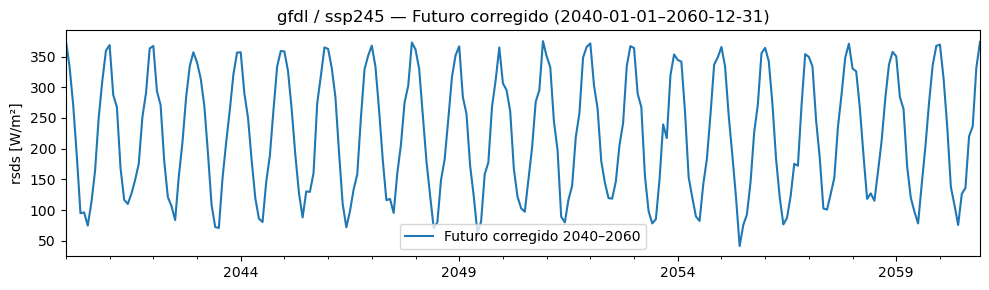

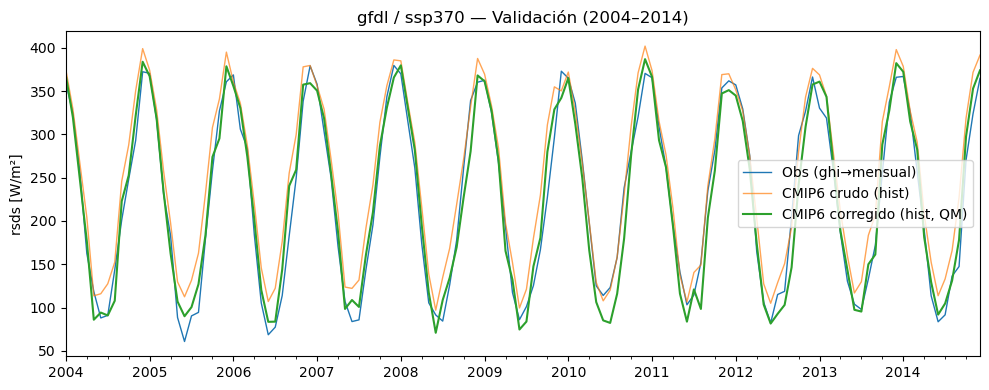

[Info] Procesando futuro ssp585 para modelo ~ 'gfdl_esm4'...
[Info] Buscando SSP 'ssp585' para modelo ~ 'gfdl_esm4' en /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/ssp585...


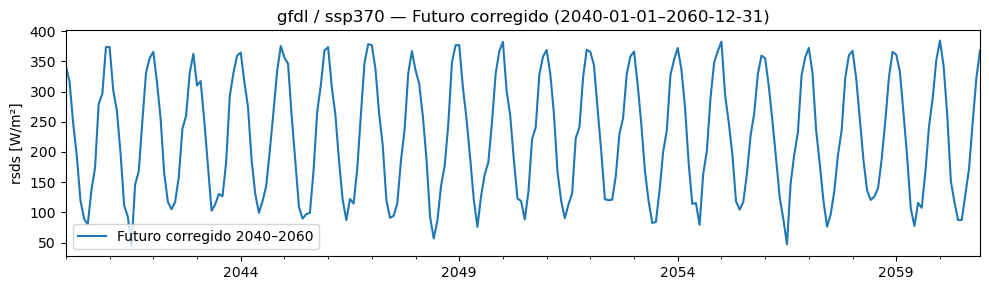

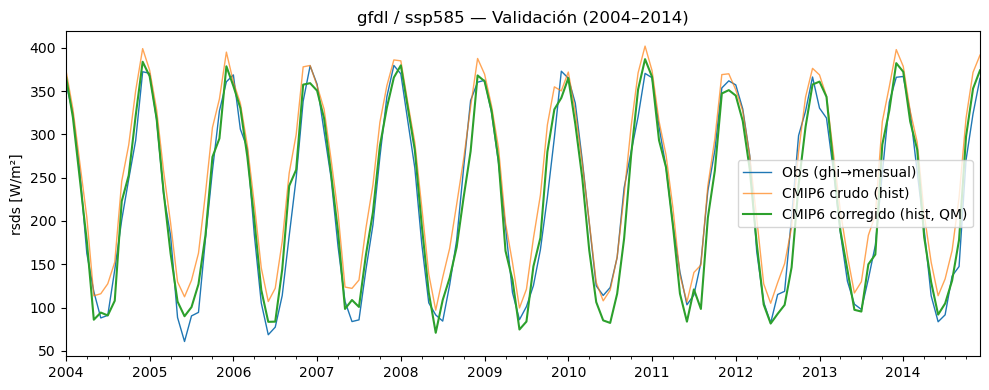

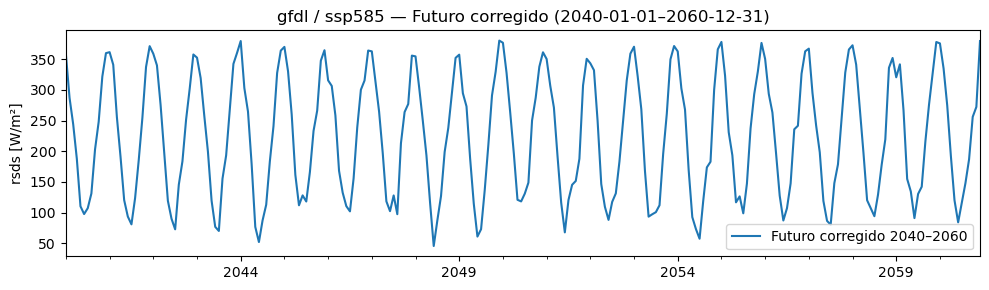

In [24]:
for model in ["access_cm2", "gfdl_esm4"]:
    for ssp in ["ssp245", "ssp370", "ssp585"]:
        run_qm_for_model(model_like=model, ssp=ssp, method="QDM")